# EDA for Game Reviews data

In [168]:
import duckdb
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [101]:
db_conn = duckdb.connect("../data/steam.duckdb")
games_df = db_conn.sql("""
SELECT * FROM game_features QUALIFY ROW_NUMBER() OVER (
    PARTITION BY game_id ORDER BY game_review_day DESC, game_scrape_date DESC
) = 1
""").pl()
db_conn.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [152]:
def show_distplot_sparse_cat(df: pl.DataFrame, col_name: str, quantiles: list | None = None, colors: list | None = None, log_scale: bool = True):
    if quantiles is None:
        quantiles = [0.25, 0.5, 0.75]
    if colors is None:
        colors = ["blue", "green", "red"]
    exploded_df = df.explode(col_name).group_by(col_name).agg(
        pl.len().alias("count"),
        (pl.sum("game_num_positive_reviews").alias("positive_reviews") / pl.len().alias("count")).alias("avg_pos_reviews"),
        pl.col("game_name")
    ).sort("avg_pos_reviews", descending=True)
    ax = sns.histplot(exploded_df["count"], bins=20, log_scale=log_scale, kde=True)
    for quant, color in zip(quantiles, colors):
        ax.axvline(exploded_df["count"].quantile(quant), color=color, linestyle="dashed", label=f"{quant} quantile ({exploded_df['count'].quantile(quant)})")
    ax.legend(title="plot stats")
    return exploded_df

In [133]:
games_df.sort("game_num_reviews", descending=True)

game_index,game_id,game_name,game_is_free,game_developers,game_publishers,game_categories,game_genres,game_steam_release_date,game_release_date,game_prerelease_date,game_short_description,game_scrape_date,game_review_score,game_review_score_description,game_review_day,game_num_reviews,game_num_positive_reviews,game_num_negative_reviews,game_weighted_score
i64,i64,str,bool,list[str],list[str],list[str],list[str],datetime[μs],"datetime[μs, America/Lima]","datetime[μs, America/Lima]",str,date,i64,str,date,i64,"decimal[38,0]","decimal[38,0]",f64
11545,578080,"""PUBG: BATTLEGROUNDS""",true,"[""PUBG Corporation""]","[""KRAFTON, Inc.""]","[""Multi-player"", ""PvP"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""Free To Play""]",2017-12-21 00:00:00,2017-12-21 00:00:00 -05,2017-03-23 10:25:15 -05,"""PUBG: BATTLEGROUNDS, the high-…",2025-08-12,5,"""Mixed""",2025-08-25,1746069,970793,775276,0.55522
950,105600,"""Terraria""",false,"[""Re-Logic""]","[""Re-Logic""]","[""Single-player"", ""Multi-player"", … ""Family Sharing""]","[""Action"", ""Adventure"", … ""RPG""]",2011-05-16 00:00:00,2011-05-16 00:00:00 -05,2011-05-16 00:00:00 -05,"""Dig, fight, explore, build! No…",2025-08-12,9,"""Overwhelmingly Positive""",2025-08-23,1141224,1114096,27128,0.978078
1959,252490,"""Rust""",false,"[""Facepunch Studios""]","[""Facepunch Studios""]","[""Multi-player"", ""MMO"", … ""Remote Play on Tablet""]","[""Action"", ""Adventure"", … ""RPG""]",2018-02-08 00:00:00,2018-02-08 00:00:00 -05,2013-12-11 13:42:09 -05,"""The only aim in Rust is to sur…",2025-08-12,8,"""Very Positive""",2025-08-21,1040475,910907,129568,0.876089
84629,2358720,"""Black Myth: Wukong""",false,"[""Game Science""]","[""Game Science""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action"", ""Adventure"", ""RPG""]",2024-08-19 00:00:00,2024-08-19 00:00:00 -05,2024-08-19 00:00:00 -05,"""Black Myth: Wukong is an actio…",2025-08-12,8,"""Very Positive""",2025-08-20,852419,822781,29638,0.96651
9202,431960,"""Wallpaper Engine""",false,"[""Wallpaper Engine Team""]","[""Wallpaper Engine Team""]","[""Steam Achievements"", ""Steam Trading Cards"", … ""Includes level editor""]","[""Casual"", ""Indie"", … ""Utilities""]",2018-11-16 00:00:00,2018-11-16 00:00:00 -05,2016-10-10 14:39:08 -05,"""Use stunning live wallpapers o…",2025-08-12,9,"""Overwhelmingly Positive""",2025-08-21,849357,832798,16559,0.980876
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
95893,1680980,"""Celestine""",false,"[""Cherry Bloom""]","[""Cherry Bloom""]","[""Single-player"", ""Steam Achievements"", … ""Steam Timeline""]","[""Adventure"", ""Casual"", … ""RPG""]",2025-03-27 00:00:00,2025-03-27 00:00:00 -05,2025-03-27 00:00:00 -05,"""Celestine, by the makers of Fi…",2025-08-12,0,"""1 user reviews""",2025-03-29,1,1,0,1.0
50872,1832260,"""Chromarena""",false,"[""Kingsnake Games""]","[""Kingsnake Games""]","[""Single-player"", ""Steam Achievements"", … ""Family Sharing""]","[""Action""]",2022-02-01 00:00:00,2022-02-01 00:00:00 -05,2022-02-01 00:00:00 -05,"""Chromarena is a 2D top-down tw…",2025-08-12,0,"""1 user reviews""",2022-02-08,1,1,0,1.0
54200,1854910,"""The Soul Box""",false,"[""Ikuku""]","[""Ikuku""]","[""Single-player"", ""Family Sharing""]","[""Casual"", ""Indie""]",2022-05-23 00:00:00,2022-05-23 00:00:00 -05,2022-05-23 00:00:00 -05,"""The Soul Box is a kinetic visu…",2025-08-12,0,"""1 user reviews""",2025-05-18,1,1,0,1.0


In [102]:
games_df["game_num_reviews"].describe()

statistic,value
str,f64
"""count""",83194.0
"""null_count""",0.0
"""mean""",1092.79204
"""std""",15383.261347
"""min""",1.0
"""25%""",4.0
"""50%""",16.0
"""75%""",86.0
"""max""",1.746069e6


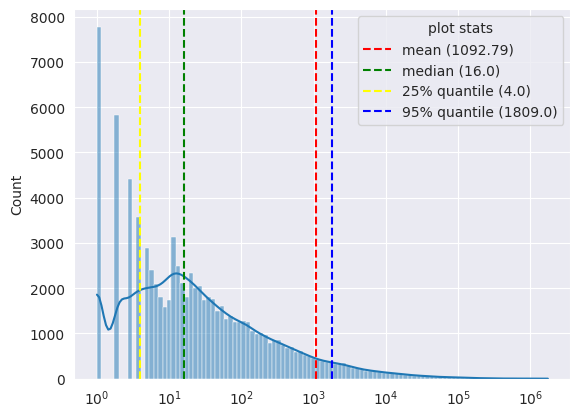

In [134]:
ax = sns.histplot(games_df["game_num_reviews"], log_scale=True, kde=True)
ax.axvline(games_df["game_num_reviews"].mean(), color="red", linestyle="dashed", label=f"mean ({games_df['game_num_reviews'].mean():.2f})")
ax.axvline(games_df["game_num_reviews"].median(), color="green", linestyle="dashed", label=f"median ({games_df['game_num_reviews'].median()})")
ax.axvline(games_df["game_num_reviews"].quantile(0.25), color="yellow", linestyle="dashed", label=f"25% quantile ({games_df['game_num_reviews'].quantile(0.25)})")
ax.axvline(games_df["game_num_reviews"].quantile(0.95), color="blue", linestyle="dashed", label=f"95% quantile ({games_df['game_num_reviews'].quantile(0.95)})")
ax.legend(title="plot stats")

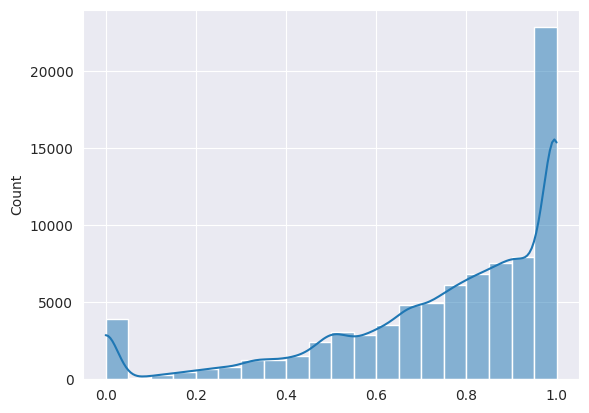

In [194]:
sns.histplot(games_df["game_weighted_score"], bins=20, kde=True)  # Too much games with score 1 ?

<Axes: ylabel='Count'>

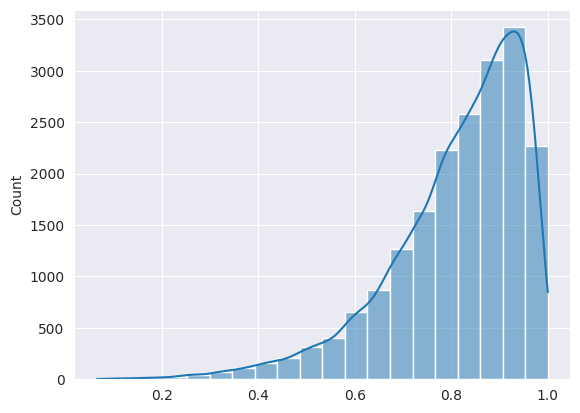

In [204]:
sns.histplot(games_df.filter(pl.col("game_num_reviews") > 100)["game_weighted_score"], bins=20, kde=True)  # less reviews are biased towards having score 1
# IDEA: feature: num_reviews_[cat] * game_score (crossed feature)

In [212]:
bottom_95_games = games_df.filter(pl.col("game_num_reviews") <= games_df["game_num_reviews"].quantile(0.95))
top_95_games = games_df.filter(pl.col("game_num_reviews") > games_df["game_num_reviews"].quantile(0.95))

<Axes: xlabel='game_num_reviews', ylabel='game_weighted_score'>

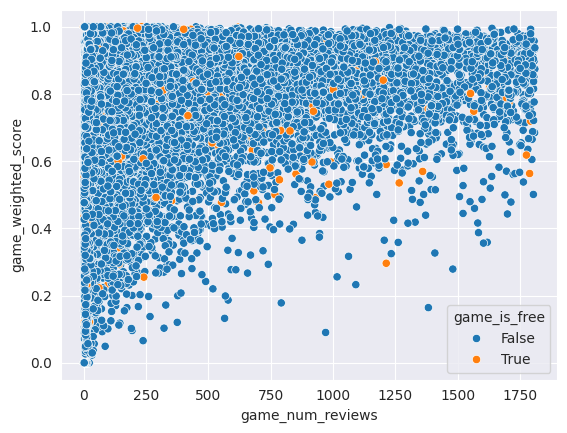

In [233]:
sns.scatterplot(x=bottom_95_games["game_num_reviews"], y=bottom_95_games["game_weighted_score"], hue=bottom_95_games["game_is_free"])

<Axes: xlabel='game_num_reviews', ylabel='game_weighted_score'>

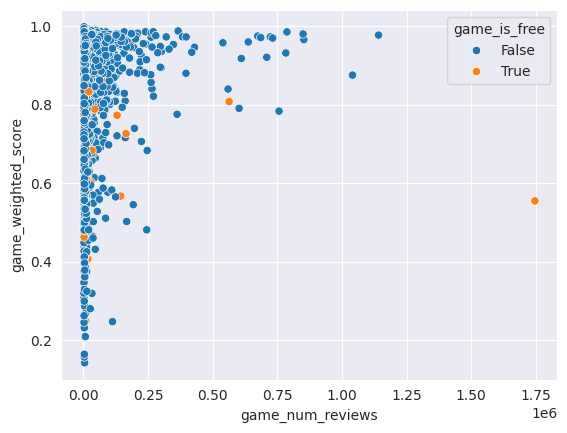

In [234]:
sns.scatterplot(x=top_95_games["game_num_reviews"], y=top_95_games["game_weighted_score"], hue=top_95_games["game_is_free"])

**NOTE**: Games score tends to increase with the number of reviews, no perceivable difference between free / non-free games

## TODO: EDA
* QUESTION: ARE THERE LARGE ENOUGH CLUSTERS (BY game_developer, game_publisher, genre, categories) TO FIND SIMILAR GAMES?
* Num reviews is biased by price, pc specs, single-player / multiplayer

    (Find similar games and try establishing bias between single-player / multiplayer and number of reviews)
* Correlation between months since release and number of reviews (positive / negative)
* Correlation between months since release and game review score
* Correlation between is_free and number of reviews (see Welch t-test, Mann-Whitney U, permutation test)
* Game developers and publishers for similar games
* Way to find similarity between games
* Analysis of game description

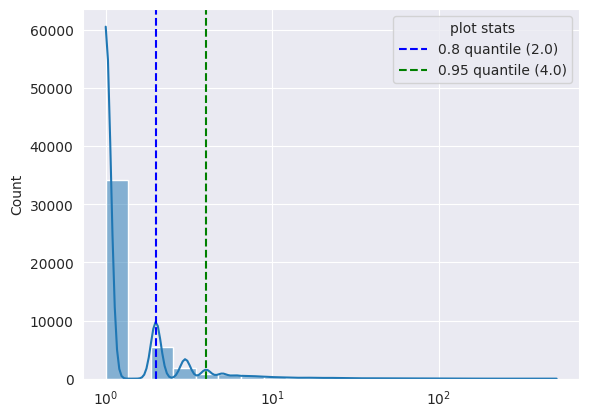

In [157]:
publishers = show_distplot_sparse_cat(games_df, "game_publishers", [0.8, 0.95])

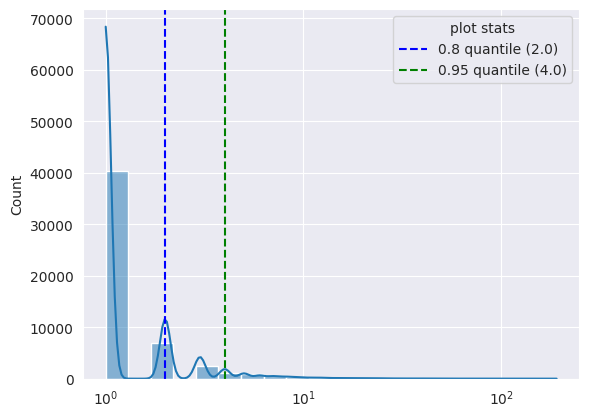

In [141]:
developers = show_distplot_sparse_cat(games_df, "game_developers", [0.8, 0.95])

**NOTE** : there are some games with empty publishers and developers

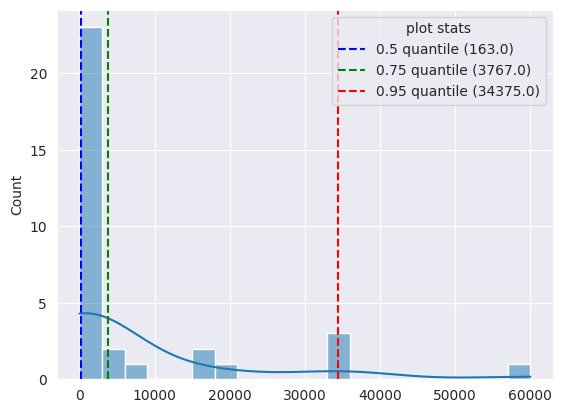

In [163]:
genres = show_distplot_sparse_cat(games_df, "game_genres", quantiles=[0.5, 0.75, 0.95], log_scale=False)

<Axes: xlabel='game_genres', ylabel='count'>

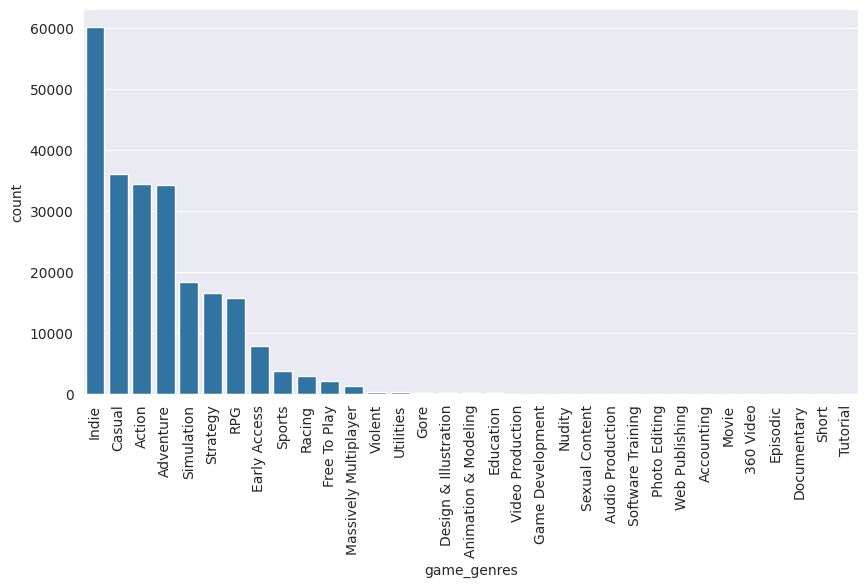

In [188]:
ax = plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
order = genres.sort("count", descending=True)["game_genres"]
sns.barplot(x=genres["game_genres"], y=genres["count"], order=order)

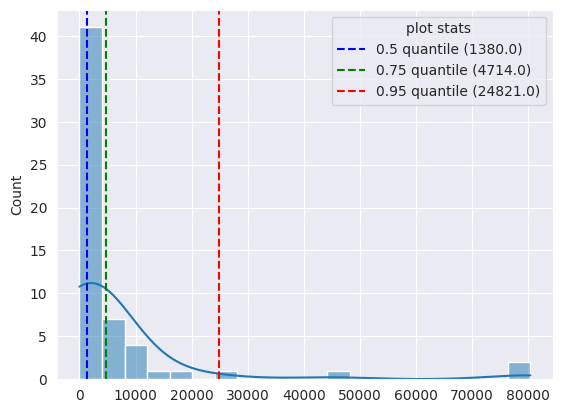

In [164]:
categories = show_distplot_sparse_cat(games_df, "game_categories", quantiles=[0.5, 0.75, 0.95], log_scale=False)

<Axes: xlabel='game_categories', ylabel='count'>

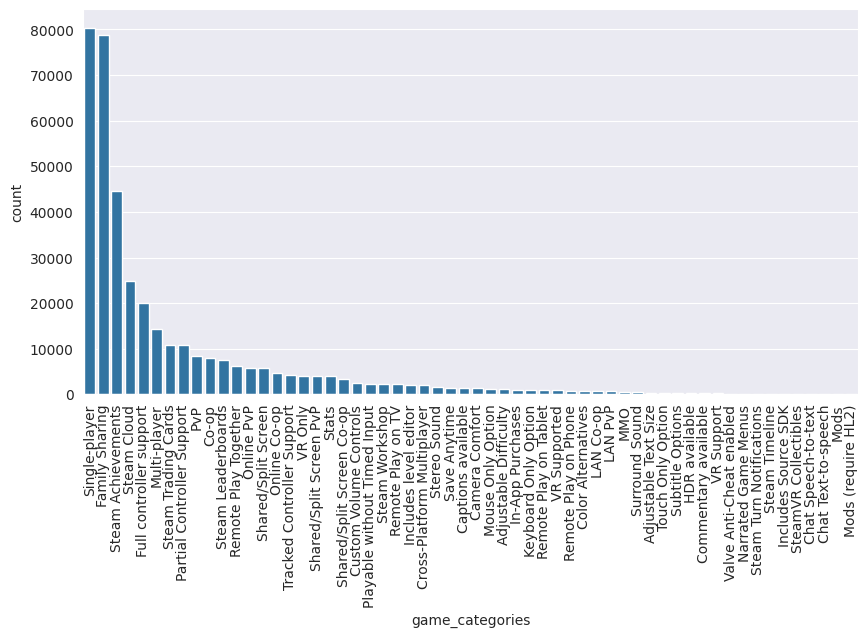

In [190]:
ax = plt.figure(figsize=(10, 5))
plt.xticks(rotation=90)
order = categories.sort("count", descending=True)["game_categories"]
sns.barplot(x=categories["game_categories"], y=categories["count"], order=order)

# Possible features for clustering methods
- description embedding
- game num reviews (25 - 50 - 75 - 95 percentiles)
- game score  (crossed with num reviews)
- is free
- publishers embedding
- developers embedding
- genre embedding
- category embedding
- months since release